In [1]:
from jax.numpy import arange, exp, sin, array, pi
from jax.lax import scan 
from functools import partial 
from ticktack import load_presaved_model
from ode import odeint as BS3
from jax.experimental.ode import odeint as DP5
import matplotlib.pyplot as plt

In [2]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5
PRODUCTION_RATE = 1.76

In [3]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None):
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [4]:
def production(t, *args, steady_state=PRODUCTION_RATE):
    start, duration, phase, area = array(list(args)).reshape(-1)

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [5]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
carbon_box_model.compile()

In [6]:
time_out = arange(-225, 775)
oversample = 1008
parameters = (774.86, 0.25, 0.8, 6.44)
growth_season = array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [7]:
_, y_initial = carbon_box_model.run(time_out, oversample, production, \
    args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

In [20]:
time_out = arange(750, 800)

In [9]:
# Running the burn-in
odeint, _ = carbon_box_model.run(time_out, oversample, production,\
    y0=y_initial, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

In [24]:
odeint = {"BS3": BS3, "DP5": DP5, "Linear": odeint_linear}
oversamples = {10: None, 20: None, 30: None, 40: None, 50: None}

In [25]:
odeint_oversample = {
    "BS3": oversamples, 
    "DP5": oversamples,
    "Linear": oversamples
}

for solver in odeint_oversample:
    for oversample in odeint_oversample[solver]:
        sol, _ = carbon_box_model.run(time_out, oversample, \
            production, solver=odeint[solver], y0=y_initial, args=parameters, \
            steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)
        
        sol = sol[:, 1]
        odeint_oversample[solver][oversample] = sol
        del sol

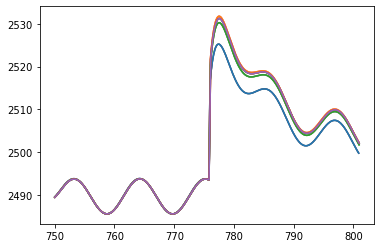

In [26]:
for solver in odeint_oversample:
    for oversample in odeint_oversample[solver]:
        time_out = arange(750, 801, 1 / oversample)
        plt.plot(time_out, odeint_oversample[solver][oversample])
        del time_out 

